In [2]:
%pip install -U transformers
%pip install -U accelerate
%pip install -U datasets
%pip install -U bertviz
%pip install -U umap-learn
%pip install -U sentencepiece
%pip install -U urllib3
%pip install py7zr

Note: you may need to restart the kernel to use updated packages.
  Using cached accelerate-1.2.0-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.2.0-py3-none-any.whl (336 kB)
Note: you may need to restart the kernel to use updated packages.

  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
Using cached datasets-3.2.0-py3-none-any.whl (480 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 2.19.1
    Uninstalling datasets-2.19.1:
      Successfully uninstalled datasets-2.19.1
  Using cached bertviz-1.4.0-py3-none-any.whl.metadata (19 kB)
  Using cached boto3-1.35.79-py3-none-any.whl.metadata (6.7 kB)
  Using cached botocore-1.35.79-py3-none-any.whl.metadata (5.7 kB)
  Using cached s3transfer-0.10.4-py3-none-any.whl.metadata (1.7 kB)
Using cached bertviz-1.4.0-py3-none-any.whl (157 kB)
Using cached boto3-1.35.79-py3-none-any.whl (139 kB)
Using cached botocore-1.35.79-py3-none-any.whl (13.3 MB)
Using cached s3transfer-0.10.4-py3-none

For Restarting and reloading

In [33]:
%reload_ext autoreload
%autoreload 2

In [34]:
from datasets import load_dataset

In [35]:
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")

In [36]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [37]:
dataset['train'][1]['article'][:300]

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many men'

In [38]:
dataset['train'][1]['highlights']

'Mentally ill inmates in Miami are housed on the "forgotten floor"\nJudge Steven Leifman says most are there as a result of "avoidable felonies"\nWhile CNN tours facility, patient shouts: "I am the son of the president"\nLeifman says the system is unjust and he\'s fighting for change .'

In [39]:
from transformers import pipeline

In [40]:
pipe = pipeline("text-generation",model="openai-community/gpt2-medium")

Device set to use cpu


In [59]:
dataset['train'][1]['article'][:1000]
input_text = dataset['train'][1]['article'][:2000]

query = input_text + "\nTL;DR:\n"

pipe_out = pipe(query, max_length=512, clean_up_tokenization_spaces=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [61]:
len(input_text)

2000

In [62]:
pipe_out[0]['generated_text']

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to foll

In [64]:
pipe_out[0]['generated_text'][len(query):]

'The ninth floor of the Miami-Dade county jail is called "the for lost floor." The jail has been the scene of nearly fifty drug arrests since 2009, when a federal grand jury indicted five members of the Miami-Dade Precinct 10 gang for drug trafficking charges. In most of these cases, the drug charges were for nonviolent or no evidence of drug use -- which is'

In [65]:
summaries = {}
summaries['gpt2-medium-380M'] = pipe_out[0]['generated_text'][len(query):]

In [66]:
pipe = pipeline('summarization', model='t5-base')

Device set to use cpu


In [67]:
pipe_out = pipe(input_text)

In [68]:
summaries['t5-base-223M'] = pipe_out[0]['summary_text']

In [69]:
summaries['t5-base-223M']

'mentally ill inmates housed on the "forgotten floor" of a pretrial detention facility in florida . inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear . a judge says the arrests often result from confrontations with police . mentally ill people often won\'t do what police say, judge says .'

In [70]:
summaries['bart-large-cnn-400M'] = pipe_out[0]['summary_text']

In [71]:
pipe_out = pipe(input_text)

In [72]:
summaries['pegasus-cnn-568M'] = pipe_out[0]['summary_text']

In [73]:
for model in summaries:
  print(model.upper())
  print(summaries[model])
  print("")

GPT2-MEDIUM-380M
The ninth floor of the Miami-Dade county jail is called "the for lost floor." The jail has been the scene of nearly fifty drug arrests since 2009, when a federal grand jury indicted five members of the Miami-Dade Precinct 10 gang for drug trafficking charges. In most of these cases, the drug charges were for nonviolent or no evidence of drug use -- which is

T5-BASE-223M
mentally ill inmates housed on the "forgotten floor" of a pretrial detention facility in florida . inmates with the most severe mental illnesses are incarcerated until they're ready to appear . a judge says the arrests often result from confrontations with police . mentally ill people often won't do what police say, judge says .

BART-LARGE-CNN-400M
mentally ill inmates housed on the "forgotten floor" of a pretrial detention facility in florida . inmates with the most severe mental illnesses are incarcerated until they're ready to appear . a judge says the arrests often result from confrontations with 

In [74]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [75]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

In [77]:
samsum = load_dataset('samsum',trust_remote_code=True)
samsum

Generating validation split: 100%|██████████| 818/818 [00:00<00:00, 5222.58 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [78]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [79]:
dialogueLen = [len(x['dialogue'].split()) for x in samsum['train']]
summaryLen = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

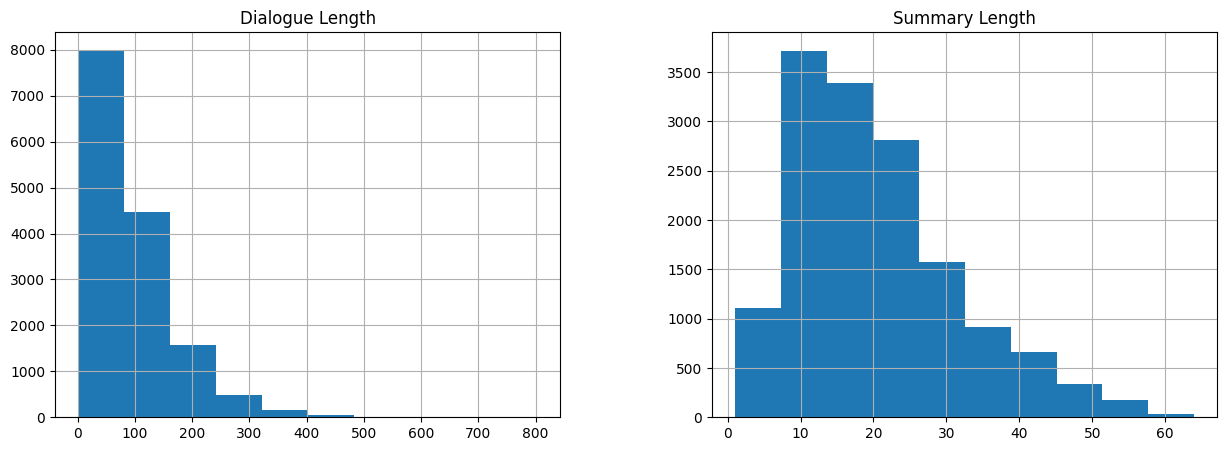

In [80]:
import pandas as pd

data = pd.DataFrame([dialogueLen, summaryLen]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))

In [81]:
def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [82]:
samsum_pt = samsum.map(get_feature, batched=True)

Map: 100%|██████████| 818/818 [00:00<00:00, 5787.53 examples/s]


In [83]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [84]:
columns = ['input_ids', 'labels', 'attention_mask']
samsum_pt.set_format(type='torch', columns=columns)

In [85]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [86]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator, train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'])

c:\Users\ramku\anaconda3\envs\teachable-python-ece5831-2024\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\ramku\AppData\Local\Temp\ipykernel_11608\870334682.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator, train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'])


In [ ]:
trainer.train()

  0%|          | 0/230 [00:00<?, ?it/s]c:\Users\ramku\anaconda3\envs\teachable-python-ece5831-2024\Lib\site-packages\transformers\data\data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_fakvb73nko\croot\pytorch-select_1730848725921\work\torch\csrc\utils\tensor_new.cpp:277.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
  3%|▎         | 6/230 [21:09<14:21:13, 230.68s/it]